In [ ]:
!pip uninstall tensorflow
!pip install tensorflow


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [31]:
# Load the prepared data
X = np.load('../data/12hrs/X_12hr.npy')
y = np.load('../data/12hrs/y_12hr.npy')


In [32]:
X.shape

(19489, 48, 52)

In [35]:
y.shape

(19489,)

In [37]:
count_ones = np.sum(y == 1)

count_zeros = np.sum(y == 0)

print(f"Number of 1s: {count_ones}")
print(f"Number of 0s: {count_zeros}")

Number of 1s: 7951
Number of 0s: 11538


In [39]:
X[0].shape

(48, 52)

In [41]:
X[0]

array([[-0.58757807, -0.83663026, -0.87412995, ..., -0.82377426,
        -0.84186686, -0.63521394],
       [-0.58757807, -0.83663026, -0.87412995, ..., -0.82377426,
        -0.84186686, -0.63521394],
       [-0.58757807, -0.83663026, -0.87412995, ..., -0.82377426,
        -0.84186686, -0.63521394],
       ...,
       [ 1.7019015 ,  1.29315507,  1.1122512 , ...,  0.99811556,
         1.0690281 ,  0.99275916],
       [ 1.7019015 ,  1.29315507,  1.1122512 , ...,  0.99811556,
         1.0690281 ,  1.26462889],
       [ 1.7019015 ,  1.29315507,  1.1122512 , ...,  1.85962935,
         1.0690281 ,  1.96022351]])

In [43]:
X[0][15]

array([-0.58757807, -0.83663026, -0.87412995, -0.82031106, -0.00669597,
       -0.00817735, -0.00252793, -0.04315573, -0.17805486, -0.13991747,
       -0.88200828, -0.87508743, -0.76989989, -0.87055823, -0.88142161,
       -0.78358441, -0.87038695, -0.88208305, -0.88220271, -0.86776175,
       -0.85036606, -0.86128536, -0.4234461 , -0.88080685, -0.8818527 ,
       -0.88166248, -0.88187548, -0.53180926, -0.88186461, -0.53819592,
       -0.87297825, -0.85484888, -0.87746256, -0.88193285, -0.88186433,
       -0.74685734, -0.87974692, -0.87776348, -0.8809766 , -0.880365  ,
       -0.87704713, -0.48722752, -0.83359775, -0.88140188, -0.02658927,
       -0.0189149 , -0.88125807, -0.83948636, -0.87836265, -0.82377426,
       -0.84186686, -0.63521394])

In [45]:
unique_values, counts = np.unique(y, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f'Value {value} occurs {count} times')

Value 0 occurs 11538 times
Value 1 occurs 7951 times


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Define Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Multi-Head Self-Attention
    attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([attention, inputs])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)  # Layer normalization

    # Feed-forward network
    ff = Dense(ff_dim, activation='relu')(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)  # Project back to original input shape
    ff = Add()([ff, attention])  # Residual connection
    ff = LayerNormalization(epsilon=1e-6)(ff)  # Layer normalization
    return ff

# Input layer
inputs = Input(shape=(48, 52))

# Transformer encoder layers
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

# Global average pooling
x = GlobalAveragePooling1D()(x)

# Dense layer
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 48, 52)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 48, 52)            │          54,068 │ input_layer_1[0][0],       │
│ (MultiHeadAttention)          │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 48, 52)            │               0 │ multi_head_attention_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 48, 52)            │               0 │ dropout_8[0][0],           │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_4         │ (None, 48, 52)            │             104 │ add_4[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 48, 128)           │           6,784 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 48, 128)           │               0 │ dense_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 48, 52)            │           6,708 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_5 (Add)                   │ (None, 48, 52)            │               0 │ dense_7[0][0],             │
│                               │                           │                 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_5         │ (None, 48, 52)            │             104 │ add_5[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 48, 52)            │          54,068 │ layer_normalization_5[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 48, 52)            │               0 │ multi_head_attention_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 48, 52)            │               0 │ dropout_11[0][0],          │
│                               │                           │                 │ layer_normalization_5[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_6         │ (None, 48, 52)            │             10

 Total params: 137,265 (536.19 KB)

 Trainable params: 137,265 (536.19 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:

# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Add Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

# Save the model
# model.save('lstm_model_advanced.h5')



Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7154 - loss: 0.5695 - val_accuracy: 0.7801 - val_loss: 0.4731
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7815 - loss: 0.4879 - val_accuracy: 0.7868 - val_loss: 0.4589
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7870 - loss: 0.4793 - val_accuracy: 0.7980 - val_loss: 0.4633
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7952 - loss: 0.4625 - val_accuracy: 0.8201 - val_loss: 0.4325
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7964 - loss: 0.4532 - val_accuracy: 0.8262 - val_loss: 0.4105
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8248 - loss: 0.4134 - val_accuracy: 0.8467 - val_loss: 0.3659
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8395 - loss: 0.3798 - val_accuracy: 0.8503 - val_loss: 0.3618
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8469 - loss: 0.3641 - val_acc

In [57]:
# Step 3: Evaluate the model
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred_proba = model.predict(X_test)
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')



122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Precision: 0.86
Recall: 0.83
F1 Score: 0.84


In [59]:

np.save('../Scores/validation_loss/T12-VL.npy', np.array(history.history['val_loss']))
np.save('../Scores/validation_accuracy/T12-VA.npy', np.array(history.history['val_accuracy']))
np.save('../Scores/training_accuracy/T12-TA.npy', np.array(history.history['accuracy']))
np.save('../Scores/training_loss/T12-TL.npy', np.array(history.history['loss']))


np.save('../Scores/ROC-PRC/T24-y_test.npy', np.array(y_test))
np.save('../Scores/ROC-PRC/T24-y_pred.npy', np.array(y_pred))
np.save('../Scores/ROC-PRC/T24-y_pred_proba.npy', np.array(y_pred_proba))


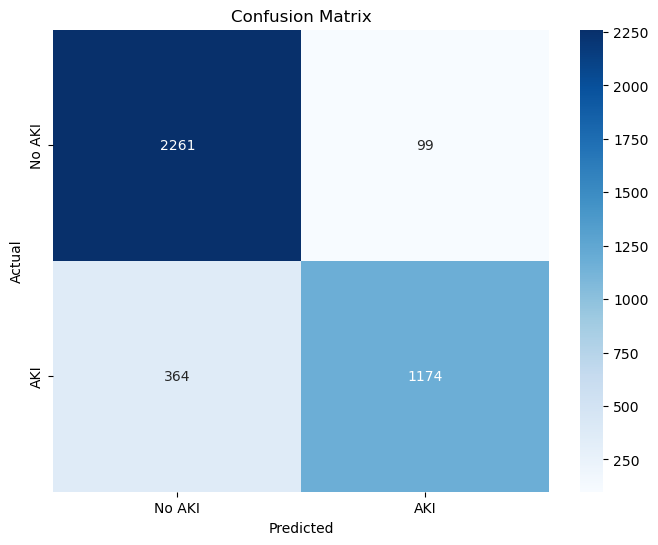

In [37]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No AKI', 'AKI'], yticklabels=['No AKI', 'AKI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Second Model


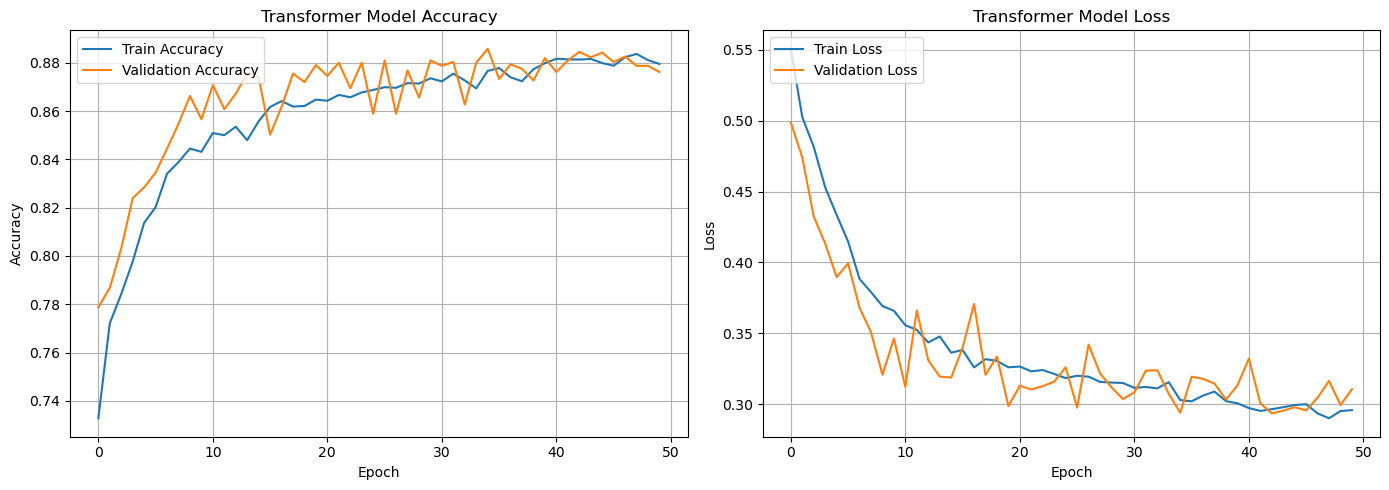

In [40]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


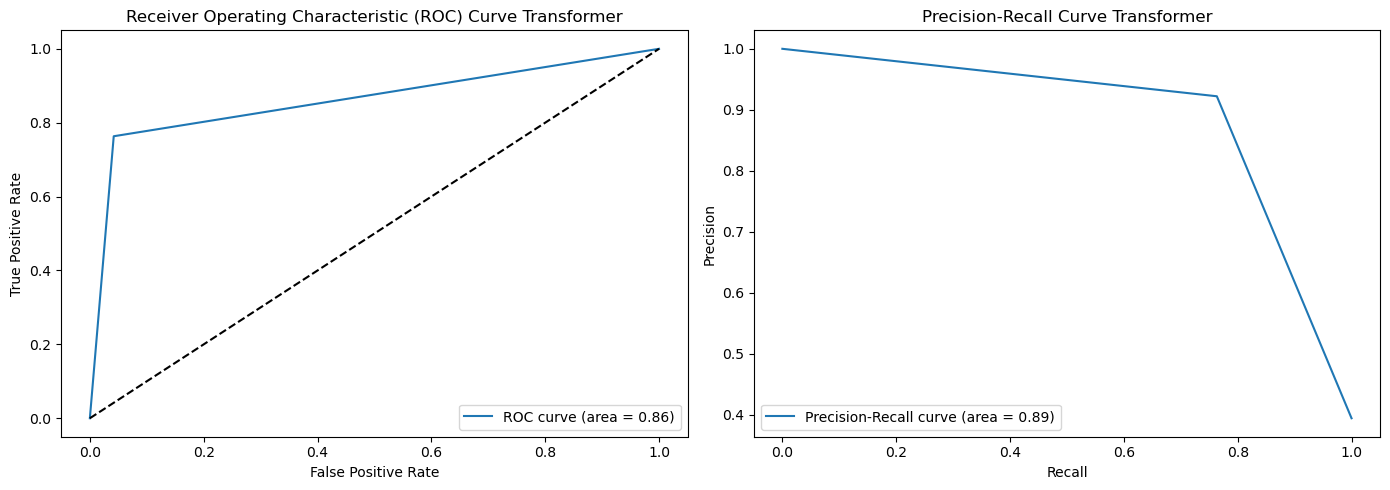

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Assuming y_true are the true labels and y_scores are the predicted probabilities

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

# Calculate Precision-Recall curve and AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve Transformer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % auprc)
plt.title('Precision-Recall Curve Transformer')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()